In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [2]:
%matplotlib inline

import shapely
import shapely.geometry as geometry
import cPickle as pickle
import matplotlib.pyplot as plt

In [3]:
groups = pickle.load(open('crawl10.pkl'))
print groups.shape
groups.head()

(7325, 12)


,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore,group
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533,4
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457,4
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471,6
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762,6
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791,6


In [4]:
groups = groups[['lat', 'lon', 'group']]

In [5]:
groups.head()

,lat,lon,group
0,37.750067,-122.441075,4
1,37.750196,-122.438933,4
2,37.756794,-122.436270,6
3,37.753529,-122.437050,6
4,37.755758,-122.433400,6


# Analyze group 0

In [6]:
g0 = groups[groups.group == 0]
g0.shape

(431, 3)

/Users/crupley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


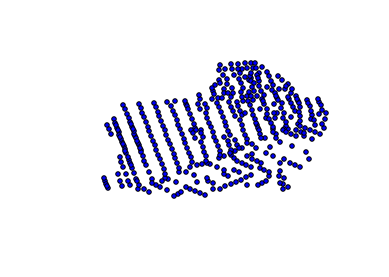

In [7]:
g0.plot(kind='scatter', x='lon', y='lat')
plt.axis('off')
plt.margins(0);

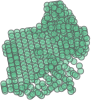

In [8]:
points = geometry.MultiPoint(zip(g0.lon, g0.lat))
points

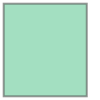

In [9]:
points.envelope

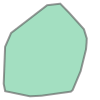

In [11]:
points.convex_hull

In [16]:
print points.convex_hull

POLYGON ((-122.4149262 37.774825, -122.4220135 37.7762879, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4220418 37.788951, -122.4203162 37.7929252, -122.4100267 37.8008532, -122.4062753 37.8012841, -122.4037825 37.7987246, -122.3995143 37.793989, -122.3987057 37.7913643, -122.3987545 37.7901007, -122.3989097 37.7882804, -122.4004581 37.7820199, -122.4027237 37.7766227, -122.4032342 37.7761656, -122.4116189 37.774997, -122.4149262 37.774825))


from http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

In [10]:
from descartes import PolygonPatch
 
def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
 
    x_min, y_min, x_max, y_max = polygon.bounds
 
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig
 
_ = plot_polygon(points.envelope)
_ = pl.plot(g0.lon,g0.lat,'o', color='#f16824')

ImportError: No module named descartes

In [19]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
 
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0]
                       for point in points])
 
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
 
concave_hull, edge_points = alpha_shape(points,
                                        alpha=1.87)

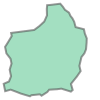

In [28]:
concave_hull, edge_points = alpha_shape(points, alpha=500)
concave_hull

In [31]:
print concave_hull

POLYGON ((-122.4027237 37.7766227, -122.4032342 37.7761656, -122.4059551 37.7770096, -122.4071553 37.7768534, -122.4094446 37.7767123, -122.4099949 37.7760366, -122.4116189 37.774997, -122.4121154 37.7753933, -122.4145362 37.7751339, -122.4149262 37.774825, -122.4175414 37.7756019, -122.4187254 37.7760734, -122.4204526 37.7767253, -122.4220135 37.7762879, -122.4221074 37.7767541, -122.4222006 37.7772211, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4209256 37.7790538, -122.4203356 37.7805572, -122.4205364 37.7814964, -122.4207265 37.7824252, -122.4201965 37.7841648, -122.4202911 37.7846322, -122.4203824 37.785096, -122.4204843 37.785564, -122.4216637 37.787081, -122.4218532 37.788019, -122.4220418 37.788951, -122.4213657 37.790001, -122.4201373 37.792044, -122.4203162 37.7929252, -122.4186681 37.7931373, -122.4170253 37.7933484, -122.415667 37.7935219, -122.4148444 37.7936274, -122.413739 37.7937713, -122.4122756 37.7948638, -122.4108545 37.796174, -122.410556 37.7968362, -122

In [35]:
from descartes import PolygonPatch

(-122.425, -122.395, 37.769999999999996, 37.805)

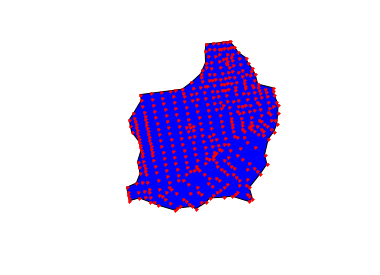

In [44]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(concave_hull, zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

In [82]:
gs = groups.group.unique()

polys = []
for g in gs:
    groupn = groups[groups.group == g]
    points = geometry.MultiPoint(zip(groupn.lon, groupn.lat))
    polygon, edge_points = alpha_shape(points, alpha=300)
    polys.append(polygon)

alpha 400 gives 'multipolygons', 300 is okay except for last one

In [83]:
polys

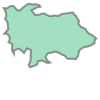

In [84]:
polys[0]

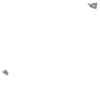

In [93]:
polys[-1]

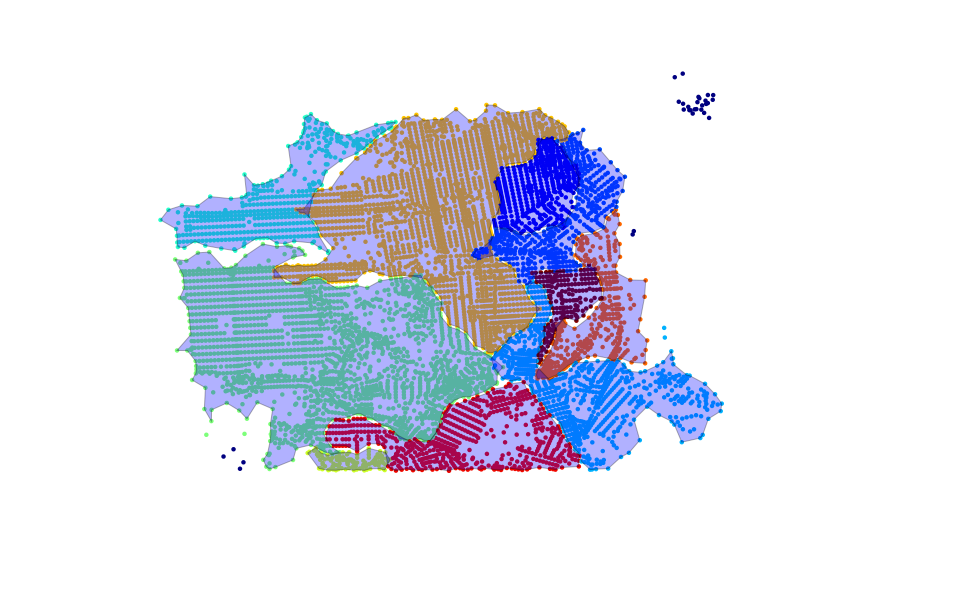

In [92]:
plt.figure(figsize=(16, 10))
plt.scatter(groups.lon, groups.lat, c=groups.group, linewidths=0)

ax = plt.gca()
for poly in polys[:-1]:
    patch = PolygonPatch(poly, zorder=1, alpha=0.3)
    ax.add_patch(patch)
plt.axis('equal')
plt.axis('off');

(-122.52, -122.38, 37.700000000000003, 37.82)

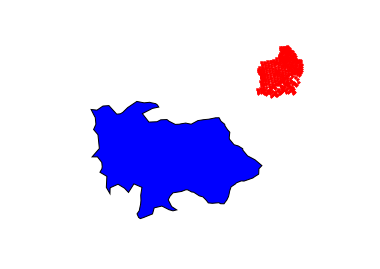

In [86]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(polys[0], zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

# Make kml file

In [100]:
from fastkml import kml

In [103]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
p = kml.Placemark(ns, 'id', 'name', 'description')
p.geometry = polys[0]
f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [105]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
for poly in polys[:-1]:
    p = kml.Placemark(ns, 'id', 'name', 'description')
    p.geometry = poly
    f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [106]:
with open('test.kml', 'wb') as f:
    f.write(k.to_string())

# GeoJSON

In [50]:
import json
import matplotlib
from shapely.geometry import mapping, shape

from code.featurize import featurizer
from code.clusterize import cut2cluster
from code.shapes import make_polys

In [5]:
fdf = pickle.load(open('featuresdf.pkl', 'rb'))
cnum = cut2cluster('010405', 17)
fdf = fdf.ix[cnum.index]

In [18]:
df = fdf.copy()
df['cnum'] = cnum
df = df[['lat', 'lon', 'cnum']]

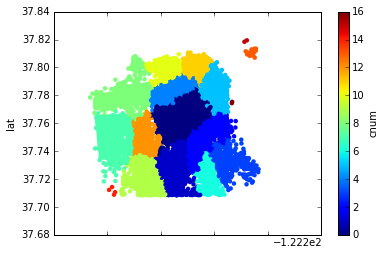

In [20]:
df.plot(kind='scatter', x='lon', y='lat', c='cnum', linewidths=0, cmap='jet')

In [22]:
polys = make_polys(df)

In [23]:
polys

In [27]:
jd = json.dumps(mapping(polys[0]))
print(jd)

{"type": "Polygon", "coordinates": [[[-122.4497124, 37.7386437], [-122.4511339, 37.7374936], [-122.4510653, 37.7399648], [-122.449965, 37.7422799], [-122.4493062, 37.7461032], [-122.4502214, 37.7521626], [-122.453141, 37.7531295], [-122.4543478, 37.7540775], [-122.4541041, 37.7560392], [-122.4531106, 37.7587055], [-122.4543702, 37.7613835], [-122.4571861, 37.7642874], [-122.4582901, 37.7648631], [-122.4594472, 37.7657366], [-122.4586481, 37.7666194], [-122.4569629, 37.7677016], [-122.454891, 37.769208], [-122.45378, 37.7717745], [-122.4532575, 37.7719981], [-122.4495459, 37.7720608], [-122.4464226, 37.7715089], [-122.4433158, 37.7728562], [-122.4420274, 37.7749318], [-122.4380828, 37.776388], [-122.4357807, 37.7776419], [-122.4341355, 37.7778515], [-122.4324908, 37.778061], [-122.4311415, 37.7782419], [-122.4276307, 37.7796412], [-122.4252785, 37.7799342], [-122.4229575, 37.7809491], [-122.4215388, 37.7820844], [-122.4200097, 37.7832341], [-122.4185821, 37.7843689], [-122.4167963, 37.7

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [46]:
geojson = {"type": "FeatureCollection",
           "features": [
            {"type": "Feature",
             "properties": {
                "color": "red"
            },
            "geometry": mapping(polys[0])
            }
    ]}

In [43]:
print json.dumps(geojson, indent=2, separators=(',', ': '))

{
  "type": "FeatureCollection",
  "features": [
    {
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -122.4497124,
              37.7386437
            ],
            [
              -122.4511339,
              37.7374936
            ],
            [
              -122.4510653,
              37.7399648
            ],
            [
              -122.449965,
              37.7422799
            ],
            [
              -122.4493062,
              37.7461032
            ],
            [
              -122.4502214,
              37.7521626
            ],
            [
              -122.453141,
              37.7531295
            ],
            [
              -122.4543478,
              37.7540775
            ],
            [
              -122.4541041,
              37.7560392
            ],
            [
              -122.4531106,
              37.7587055
            ],
            [
              -122.4543702,
 

In [44]:
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))

In [36]:
with open('results/geojsontest.json', 'wb') as f:
    json.dump(geojson, f)

In [53]:
c = matplotlib.cm.get_cmap('Set1')
clist = [matplotlib.colors.rgb2hex(rgb) for rgb in c(np.linspace(0,1,len(polys)))]
clist

[u'#e41a1c',
 u'#825274',
 u'#3a84aa',
 u'#46a06c',
 u'#639364',
 u'#8d5c96',
 u'#c3635f',
 u'#ff8101',
 u'#ffc91e',
 u'#f2e631',
 u'#c0872b',
 u'#bf6356',
 u'#ed7bab',
 u'#ce8bae',
 u'#999999']

In [59]:
mapnos = ['010405' if i%2 == 0 else '010406' for i in range(len(polys)) ]
mapnos

['010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405']

In [60]:
# all polygons
featurelist = []
for i, poly in enumerate(polys):
    featurelist.append({"type": "Feature",
                        "properties": {
                        "color": clist[i],
                        "mapno": mapnos[i]
                        },
                        "geometry": mapping(poly)
                        })
    
geojson = {"type": "FeatureCollection",
           "features": featurelist}

SyntaxError: invalid syntax (<ipython-input-60-6fd88f614b3d>, line 7)

In [57]:
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))